# Attention Mechanisms in Transformers: A Comprehensive Guide

This notebook provides a thorough implementation of attention mechanisms from scratch, implementing modern transformer attention mechanisms. We'll build up from basic self-attention to multi-head attention with rotary embeddings and KV caching.

## Table of Contents
1. [Introduction to Attention](#introduction)
2. [Scaled Dot-Product Attention](#scaled-dot-product)
3. [Multi-Head Attention](#multi-head)
4. [Causal Self-Attention](#causal-attention)
5. [Rotary Position Embeddings in Attention](#rope-attention)
6. [Grouped Query Attention (GQA)](#gqa)
7. [KV Caching for Efficient Inference](#kv-cache)
8. [Complete Implementation](#complete-implementation)
9. [Visualization and Analysis](#visualization)
10. [Performance Comparison](#performance)

## Introduction to Attention

Attention mechanisms allow models to focus on different parts of the input when processing each element. In transformers, attention is the core mechanism that enables the model to capture relationships between tokens.

### Key Concepts in Modern Attention:
- **Causal Self-Attention**: Each token can only attend to itself and previous tokens
- **Multi-Head Attention**: Multiple parallel attention operations capture different relationships
- **Rotary Embeddings (RoPE)**: Applied to queries and keys for positional information
- **Grouped Query Attention (GQA)**: Efficiency optimization with fewer key/value heads
- **KV Caching**: Store past keys/values for efficient autoregressive generation
- **Flash Attention**: Optimized attention computation via PyTorch's `scaled_dot_product_attention`

### The Attention Formula

For a query $Q$, key $K$, and value $V$:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

where $d_k$ is the dimension of the key vectors.

## Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from typing import Optional, Tuple

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.1+cu128


## Scaled Dot-Product Attention

The foundation of all attention mechanisms is the scaled dot-product attention. Let's implement it from scratch to understand how it works.

In [2]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Compute scaled dot-product attention.
    
    Args:
        query: Query tensor of shape (batch, seq_len_q, d_k)
        key: Key tensor of shape (batch, seq_len_k, d_k)
        value: Value tensor of shape (batch, seq_len_k, d_v)
        mask: Optional mask tensor of shape (batch, seq_len_q, seq_len_k)
              where masked positions have value -inf or False
    
    Returns:
        output: Attention output of shape (batch, seq_len_q, d_v)
        attention_weights: Attention weights of shape (batch, seq_len_q, seq_len_k)
    """
    # Get dimension of keys for scaling
    d_k = query.shape[-1]
    
    # Compute attention scores: Q @ K^T / sqrt(d_k)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    # Apply mask if provided
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    
    # Apply softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Apply attention weights to values
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights

# Test with simple example
batch_size = 2
seq_len = 4
d_model = 8

# Create random query, key, value tensors
query = torch.randn(batch_size, seq_len, d_model)
key = torch.randn(batch_size, seq_len, d_model)
value = torch.randn(batch_size, seq_len, d_model)

# Compute attention
output, attention_weights = scaled_dot_product_attention(query, key, value)

print(f"Query shape: {query.shape}")
print(f"Key shape: {key.shape}")
print(f"Value shape: {value.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"\nSample attention weights (first batch, all positions):")
print(attention_weights[0])
print(f"\nSum of attention weights per row (should be ~1.0):")
print(attention_weights[0].sum(dim=-1))

Query shape: torch.Size([2, 4, 8])
Key shape: torch.Size([2, 4, 8])
Value shape: torch.Size([2, 4, 8])
Output shape: torch.Size([2, 4, 8])
Attention weights shape: torch.Size([2, 4, 4])

Sample attention weights (first batch, all positions):
tensor([[0.5092, 0.3165, 0.1113, 0.0631],
        [0.2619, 0.3828, 0.1773, 0.1779],
        [0.2445, 0.0241, 0.2013, 0.5302],
        [0.7451, 0.1075, 0.0349, 0.1124]])

Sum of attention weights per row (should be ~1.0):
tensor([1.0000, 1.0000, 1.0000, 1.0000])


### Visualizing Attention Weights

Let's visualize the attention pattern to understand how different positions attend to each other.

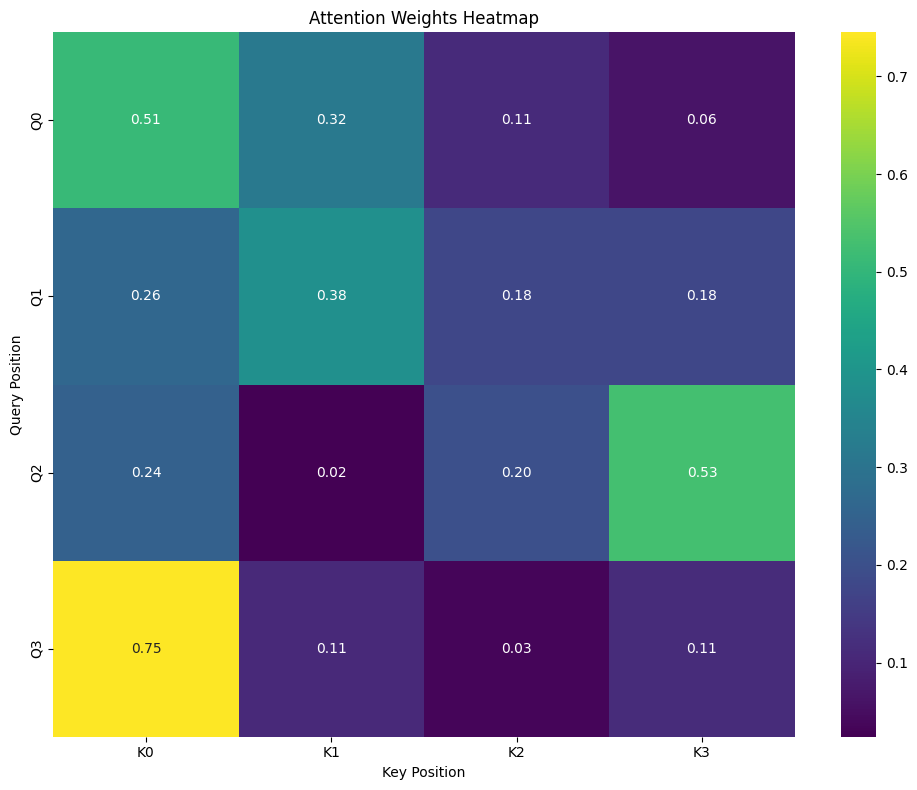

In [3]:
# Visualize attention weights
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights[0].detach().numpy(), 
            annot=True, fmt='.2f', cmap='viridis',
            xticklabels=[f'K{i}' for i in range(seq_len)],
            yticklabels=[f'Q{i}' for i in range(seq_len)])
plt.title('Attention Weights Heatmap')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.tight_layout()
plt.show()

## Causal Self-Attention

In language modeling, we need causal (autoregressive) attention where each position can only attend to itself and previous positions. This is achieved using a causal mask.

Causal mask shape: torch.Size([6, 6])
Causal mask:
tensor([[1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]], dtype=torch.int32)



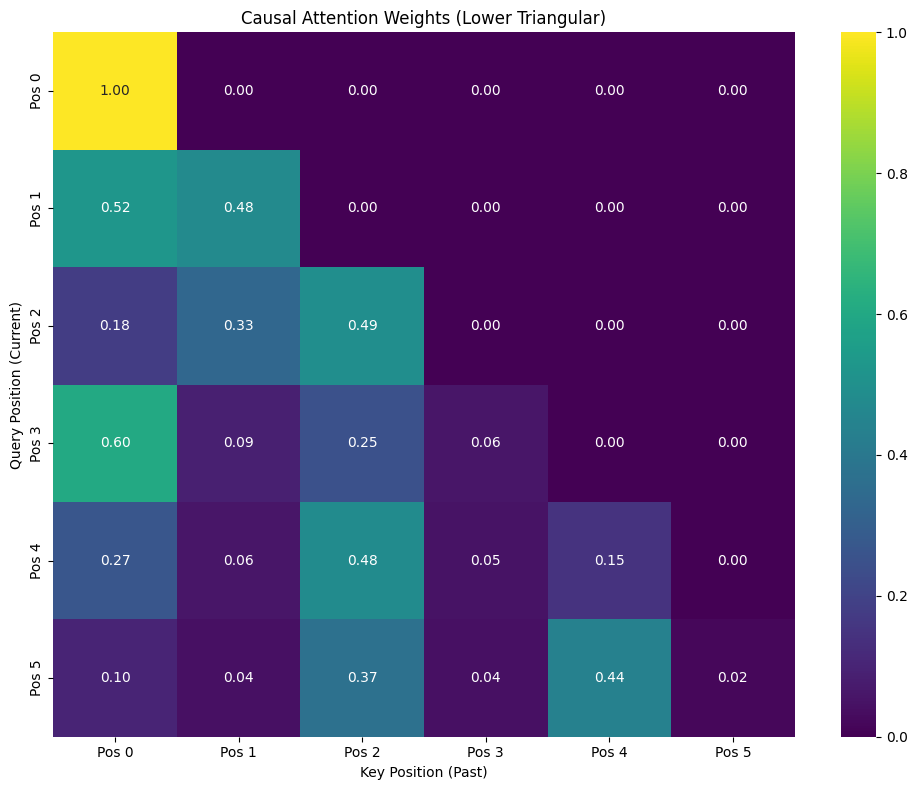


Notice how each position (row) only attends to itself and previous positions (columns)


In [4]:
def create_causal_mask(seq_len):
    """
    Create a causal (lower triangular) mask.
    
    Args:
        seq_len: Sequence length
    
    Returns:
        mask: Boolean mask of shape (seq_len, seq_len) where True indicates 
              positions that can be attended to
    """
    mask = torch.tril(torch.ones(seq_len, seq_len)).bool()
    return mask

# Create and visualize causal mask
seq_len = 6
causal_mask = create_causal_mask(seq_len)

print(f"Causal mask shape: {causal_mask.shape}")
print(f"Causal mask:\n{causal_mask.int()}\n")

# Apply causal attention
query = torch.randn(1, seq_len, d_model)
key = torch.randn(1, seq_len, d_model)
value = torch.randn(1, seq_len, d_model)

output, causal_attention_weights = scaled_dot_product_attention(
    query, key, value, mask=causal_mask
)

# Visualize causal attention
plt.figure(figsize=(10, 8))
sns.heatmap(causal_attention_weights[0].detach().numpy(), 
            annot=True, fmt='.2f', cmap='viridis',
            xticklabels=[f'Pos {i}' for i in range(seq_len)],
            yticklabels=[f'Pos {i}' for i in range(seq_len)])
plt.title('Causal Attention Weights (Lower Triangular)')
plt.xlabel('Key Position (Past)')
plt.ylabel('Query Position (Current)')
plt.tight_layout()
plt.show()

print(f"\nNotice how each position (row) only attends to itself and previous positions (columns)")

## Multi-Head Attention

Multi-head attention runs multiple attention operations in parallel, allowing the model to attend to information from different representation subspaces. This is the foundation of transformer models.

In [5]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention module.
    
    Args:
        n_embd: Embedding dimension
        n_head: Number of attention heads
        dropout: Dropout rate
    """
    def __init__(self, n_embd, n_head, dropout=0.1):
        super().__init__()
        assert n_embd % n_head == 0, "n_embd must be divisible by n_head"
        
        self.n_embd = n_embd
        self.n_head = n_head
        self.head_dim = n_embd // n_head
        
        # Query, Key, Value projections for all heads (combined)
        self.c_q = nn.Linear(n_embd, n_embd)
        self.c_k = nn.Linear(n_embd, n_embd)
        self.c_v = nn.Linear(n_embd, n_embd)
        
        # Output projection
        self.c_proj = nn.Linear(n_embd, n_embd)
        
        # Dropout
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Input tensor of shape (batch, seq_len, n_embd)
            mask: Optional attention mask
        
        Returns:
            output: Attention output of shape (batch, seq_len, n_embd)
        """
        B, T, C = x.shape  # batch, sequence length, embedding dimensionality
        
        # Calculate query, key, values for all heads
        q = self.c_q(x)  # (B, T, n_embd)
        k = self.c_k(x)  # (B, T, n_embd)
        v = self.c_v(x)  # (B, T, n_embd)
        
        # Split into multiple heads: (B, T, n_embd) -> (B, T, n_head, head_dim) -> (B, n_head, T, head_dim)
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        
        # Compute attention scores
        # (B, n_head, T, head_dim) @ (B, n_head, head_dim, T) -> (B, n_head, T, T)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        # Apply softmax and dropout
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        
        # Apply attention to values
        # (B, n_head, T, T) @ (B, n_head, T, head_dim) -> (B, n_head, T, head_dim)
        out = torch.matmul(attn_weights, v)
        
        # Concatenate heads: (B, n_head, T, head_dim) -> (B, T, n_head, head_dim) -> (B, T, n_embd)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        
        # Output projection
        out = self.c_proj(out)
        out = self.resid_dropout(out)
        
        return out

# Test Multi-Head Attention
n_embd = 128
n_head = 8
batch_size = 2
seq_len = 10

mha = MultiHeadAttention(n_embd, n_head)
x = torch.randn(batch_size, seq_len, n_embd)
causal_mask = create_causal_mask(seq_len)

output = mha(x, mask=causal_mask)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Number of heads: {n_head}")
print(f"Head dimension: {n_embd // n_head}")
print(f"Total parameters: {sum(p.numel() for p in mha.parameters()):,}")

Input shape: torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])
Number of heads: 8
Head dimension: 16
Total parameters: 66,048


## Rotary Position Embeddings (RoPE) in Attention

RoPE is applied to the query and key tensors before computing attention. This provides better positional information than absolute positional embeddings.

RoPE rotates the embedding vectors based on their positions, allowing the model to capture relative distances between tokens.

In [7]:
def apply_rotary_emb(x: torch.Tensor, cos_sin: torch.Tensor) -> torch.Tensor:
    """
    Apply rotary position embeddings to input tensor.
    
    Args:
        x: Input tensor of shape (..., seq_len, dim)
        cos_sin: Precomputed cos and sin values of shape (seq_len, dim)
    
    Returns:
        Rotated tensor of same shape as input
    """
    # Split x into two halves
    x1, x2 = x.chunk(2, dim=-1)
    
    # Split cos_sin into cos and sin
    cos, sin = cos_sin.chunk(2, dim=-1)
    
    # Apply rotation
    # [x1, x2] rotated by theta becomes [x1*cos - x2*sin, x1*sin + x2*cos]
    rotated_x1 = x1 * cos - x2 * sin
    rotated_x2 = x1 * sin + x2 * cos
    
    # Concatenate back
    return torch.cat([rotated_x1, rotated_x2], dim=-1)

def precompute_freqs_cis(dim: int, seq_len: int, theta: float = 10000.0):
    """
    Precompute the frequency tensor for rotary embeddings.
    
    Args:
        dim: Dimension of the embeddings (must be even)
        seq_len: Maximum sequence length
        theta: Base for frequency calculation
    
    Returns:
        Tensor of shape (seq_len, dim) containing cos and sin values
    """
    # Compute frequencies for the pair dimensions (dim // 2)
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2).float() / dim))
    
    # Create position indices
    t = torch.arange(seq_len, dtype=torch.float32)
    
    # Compute outer product -> shape (seq_len, dim//2)
    freqs = torch.outer(t, freqs)
    
    # Compute cos and sin -> shapes (seq_len, dim//2) each
    cos = torch.cos(freqs)
    sin = torch.sin(freqs)
    
    # Concatenate cos and sin along the last dimension -> (seq_len, dim)
    freqs_cis = torch.cat([cos, sin], dim=-1)
    
    return freqs_cis

# Test RoPE
dim = 64
seq_len = 10
freqs_cis = precompute_freqs_cis(dim, seq_len)

print(f"Frequency tensor shape: {freqs_cis.shape}")
print(f"Expected shape: ({seq_len}, {dim})")

# Test applying RoPE to a sample tensor
x = torch.randn(2, seq_len, dim)  # (batch, seq_len, dim)
rotated_x = apply_rotary_emb(x, freqs_cis)

print(f"\nInput shape: {x.shape}")
print(f"Rotated output shape: {rotated_x.shape}")
print(f"Shapes match: {x.shape == rotated_x.shape}")

Frequency tensor shape: torch.Size([10, 64])
Expected shape: (10, 64)

Input shape: torch.Size([2, 10, 64])
Rotated output shape: torch.Size([2, 10, 64])
Shapes match: True


In [8]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    Repeat key/value heads to match the number of query heads.
    
    Args:
        x: Tensor of shape (batch, n_kv_head, seq_len, head_dim)
        n_rep: Number of repetitions
    
    Returns:
        Tensor of shape (batch, n_kv_head * n_rep, seq_len, head_dim)
    """
    if n_rep == 1:
        return x
    
    batch, n_kv_head, seq_len, head_dim = x.shape
    
    # Repeat along the head dimension
    # (B, n_kv_head, 1, T, head_dim) -> (B, n_kv_head, n_rep, T, head_dim) -> (B, n_kv_head * n_rep, T, head_dim)
    x = x[:, :, None, :, :].expand(batch, n_kv_head, n_rep, seq_len, head_dim)
    return x.reshape(batch, n_kv_head * n_rep, seq_len, head_dim)

# Demonstrate GQA
n_head = 8
n_kv_head = 2  # Fewer KV heads
batch = 2
seq_len = 10
head_dim = 16

# Simulate key/value tensors with fewer heads
kv = torch.randn(batch, n_kv_head, seq_len, head_dim)
print(f"Original KV shape: {kv.shape}")

# Repeat to match query heads
n_rep = n_head // n_kv_head
kv_repeated = repeat_kv(kv, n_rep)
print(f"Repeated KV shape: {kv_repeated.shape}")
print(f"Number of repetitions per KV head: {n_rep}")

# Verify shapes
assert kv_repeated.shape[1] == n_head, "Number of heads should match query heads"
print(f"\n✓ GQA: {n_kv_head} KV heads repeated to {n_head} heads (ratio 1:{n_rep})")

Original KV shape: torch.Size([2, 2, 10, 16])
Repeated KV shape: torch.Size([2, 8, 10, 16])
Number of repetitions per KV head: 4

✓ GQA: 2 KV heads repeated to 8 heads (ratio 1:4)


In [9]:
class KVCache:
    """
    Key-Value cache for efficient autoregressive generation.
    """
    def __init__(self, max_batch_size: int, max_seq_len: int, n_kv_head: int, head_dim: int, dtype=torch.float32):
        self.max_batch_size = max_batch_size
        self.max_seq_len = max_seq_len
        self.n_kv_head = n_kv_head
        self.head_dim = head_dim
        
        # Initialize cache tensors
        self.cache_k = torch.zeros(
            max_batch_size, n_kv_head, max_seq_len, head_dim, dtype=dtype
        )
        self.cache_v = torch.zeros(
            max_batch_size, n_kv_head, max_seq_len, head_dim, dtype=dtype
        )
        
        self.current_len = 0
    
    def update(self, k: torch.Tensor, v: torch.Tensor, start_pos: int):
        """
        Update cache with new keys and values.
        
        Args:
            k: New keys of shape (batch, n_kv_head, new_tokens, head_dim)
            v: New values of shape (batch, n_kv_head, new_tokens, head_dim)
            start_pos: Starting position in the cache
        
        Returns:
            Updated keys and values from cache
        """
        batch_size, n_kv_head, new_tokens, head_dim = k.shape
        
        # Update cache
        end_pos = start_pos + new_tokens
        self.cache_k[:batch_size, :, start_pos:end_pos, :] = k
        self.cache_v[:batch_size, :, start_pos:end_pos, :] = v
        
        self.current_len = end_pos
        
        # Return all cached values up to current position
        return (
            self.cache_k[:batch_size, :, :end_pos, :],
            self.cache_v[:batch_size, :, :end_pos, :]
        )
    
    def reset(self):
        """Reset the cache."""
        self.current_len = 0
        self.cache_k.zero_()
        self.cache_v.zero_()

# Demonstrate KV caching
batch_size = 1
max_seq_len = 100
n_kv_head = 4
head_dim = 32

kv_cache = KVCache(batch_size, max_seq_len, n_kv_head, head_dim)

print("Simulating autoregressive generation with KV caching:")
print(f"Maximum sequence length: {max_seq_len}")
print(f"Number of KV heads: {n_kv_head}")
print(f"Head dimension: {head_dim}\n")

# Simulate generating 5 tokens
for step in range(5):
    # New token (only 1 at a time during generation)
    new_k = torch.randn(batch_size, n_kv_head, 1, head_dim)
    new_v = torch.randn(batch_size, n_kv_head, 1, head_dim)
    
    # Update cache
    cached_k, cached_v = kv_cache.update(new_k, new_v, start_pos=step)
    
    print(f"Step {step + 1}:")
    print(f"  New K/V shape: {new_k.shape}")
    print(f"  Cached K/V shape: {cached_k.shape}")
    print(f"  Cache length: {kv_cache.current_len}")
    print(f"  Memory saved: Reusing {step} previous token computations\n")

print(f"✓ KV cache stores keys/values to avoid recomputing attention for past tokens")

Simulating autoregressive generation with KV caching:
Maximum sequence length: 100
Number of KV heads: 4
Head dimension: 32

Step 1:
  New K/V shape: torch.Size([1, 4, 1, 32])
  Cached K/V shape: torch.Size([1, 4, 1, 32])
  Cache length: 1
  Memory saved: Reusing 0 previous token computations

Step 2:
  New K/V shape: torch.Size([1, 4, 1, 32])
  Cached K/V shape: torch.Size([1, 4, 2, 32])
  Cache length: 2
  Memory saved: Reusing 1 previous token computations

Step 3:
  New K/V shape: torch.Size([1, 4, 1, 32])
  Cached K/V shape: torch.Size([1, 4, 3, 32])
  Cache length: 3
  Memory saved: Reusing 2 previous token computations

Step 4:
  New K/V shape: torch.Size([1, 4, 1, 32])
  Cached K/V shape: torch.Size([1, 4, 4, 32])
  Cache length: 4
  Memory saved: Reusing 3 previous token computations

Step 5:
  New K/V shape: torch.Size([1, 4, 1, 32])
  Cached K/V shape: torch.Size([1, 4, 5, 32])
  Cache length: 5
  Memory saved: Reusing 4 previous token computations

✓ KV cache stores keys/va

In [10]:
class CausalSelfAttention(nn.Module):
    """
    Causal Self-Attention module implementing modern transformer architectures.
    
    Features:
    - Multi-head attention with separate Q, K, V projections
    - Rotary position embeddings (RoPE)
    - Grouped Query Attention (GQA) support
    - KV caching for efficient inference
    - RMS normalization for queries and keys
    """
    def __init__(self, n_embd: int, n_head: int, n_kv_head: int, max_seq_len: int = 1024, dropout: float = 0.0):
        super().__init__()
        assert n_embd % n_head == 0, "n_embd must be divisible by n_head"
        assert n_head % n_kv_head == 0, "n_head must be divisible by n_kv_head"
        
        self.n_embd = n_embd
        self.n_head = n_head
        self.n_kv_head = n_kv_head
        self.head_dim = n_embd // n_head
        self.n_rep = n_head // n_kv_head  # Repetition factor for GQA
        
        # Query, Key, Value projections
        self.c_q = nn.Linear(n_embd, n_embd, bias=False)
        self.c_k = nn.Linear(n_embd, n_kv_head * self.head_dim, bias=False)
        self.c_v = nn.Linear(n_embd, n_kv_head * self.head_dim, bias=False)
        
        # Output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        
        # Dropout
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        
        # Precompute RoPE frequencies
        self.register_buffer(
            "freqs_cis",
            precompute_freqs_cis(self.head_dim, max_seq_len)
        )
        
    def forward(self, x: torch.Tensor, kv_cache: Optional[KVCache] = None, start_pos: int = 0):
        """
        Args:
            x: Input tensor of shape (batch, seq_len, n_embd)
            kv_cache: Optional KV cache for inference
            start_pos: Starting position (for KV cache)
        
        Returns:
            output: Attention output of shape (batch, seq_len, n_embd)
        """
        B, T, C = x.shape
        
        # Compute Q, K, V
        q = self.c_q(x)  # (B, T, n_embd)
        k = self.c_k(x)  # (B, T, n_kv_head * head_dim)
        v = self.c_v(x)  # (B, T, n_kv_head * head_dim)
        
        # Reshape for multi-head attention
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # (B, n_head, T, head_dim)
        k = k.view(B, T, self.n_kv_head, self.head_dim).transpose(1, 2)  # (B, n_kv_head, T, head_dim)
        v = v.view(B, T, self.n_kv_head, self.head_dim).transpose(1, 2)  # (B, n_kv_head, T, head_dim)
        
        # Apply RoPE to queries and keys
        # Get frequencies for current positions
        freqs = self.freqs_cis[start_pos:start_pos + T]
        
        # Reshape for broadcasting: (T, head_dim*2) -> (1, 1, T, head_dim*2)
        freqs = freqs.unsqueeze(0).unsqueeze(0)
        
        # Apply rotary embeddings
        q = apply_rotary_emb(q, freqs)
        k = apply_rotary_emb(k, freqs)
        
        # Apply RMS normalization (common in modern transformer architectures)
        q = F.rms_norm(q, (self.head_dim,))
        k = F.rms_norm(k, (self.head_dim,))
        
        # Update KV cache if provided
        if kv_cache is not None:
            k, v = kv_cache.update(k, v, start_pos)
        
        # Repeat K/V heads if using GQA
        if self.n_rep > 1:
            k = repeat_kv(k, self.n_rep)
            v = repeat_kv(v, self.n_rep)
        
        # Compute attention using PyTorch's optimized function (Flash Attention)
        # This automatically applies causal masking when is_causal=True
        out = F.scaled_dot_product_attention(
            q, k, v,
            attn_mask=None,
            dropout_p=self.attn_dropout.p if self.training else 0.0,
            is_causal=(kv_cache is None)  # Only causal during training
        )
        
        # Reshape and project output
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.c_proj(out)
        out = self.resid_dropout(out)
        
        return out

# Test the complete implementation
n_embd = 256
n_head = 8
n_kv_head = 4  # GQA: half the number of KV heads
max_seq_len = 512
batch_size = 2
seq_len = 16

attention = CausalSelfAttention(n_embd, n_head, n_kv_head, max_seq_len)
attention.eval()  # Set to eval mode

# Test without KV cache (training mode)
x = torch.randn(batch_size, seq_len, n_embd)
output = attention(x)

print("Training Mode (no KV cache):")
print(f"  Input shape: {x.shape}")
print(f"  Output shape: {output.shape}")
print(f"  Number of parameters: {sum(p.numel() for p in attention.parameters()):,}")
print(f"  GQA configuration: {n_head} query heads, {n_kv_head} KV heads (ratio 1:{n_head // n_kv_head})")

# Test with KV cache (inference mode)
print("\nInference Mode (with KV cache):")
kv_cache = KVCache(batch_size, max_seq_len, n_kv_head, attention.head_dim)

# Generate 3 tokens autoregressively
for i in range(3):
    token = torch.randn(batch_size, 1, n_embd)  # Single token
    output = attention(token, kv_cache=kv_cache, start_pos=i)
    print(f"  Step {i+1}: Input {token.shape} -> Output {output.shape}, Cache len: {kv_cache.current_len}")

Training Mode (no KV cache):
  Input shape: torch.Size([2, 16, 256])
  Output shape: torch.Size([2, 16, 256])
  Number of parameters: 196,608
  GQA configuration: 8 query heads, 4 KV heads (ratio 1:2)

Inference Mode (with KV cache):
  Step 1: Input torch.Size([2, 1, 256]) -> Output torch.Size([2, 1, 256]), Cache len: 1
  Step 2: Input torch.Size([2, 1, 256]) -> Output torch.Size([2, 1, 256]), Cache len: 2
  Step 3: Input torch.Size([2, 1, 256]) -> Output torch.Size([2, 1, 256]), Cache len: 3


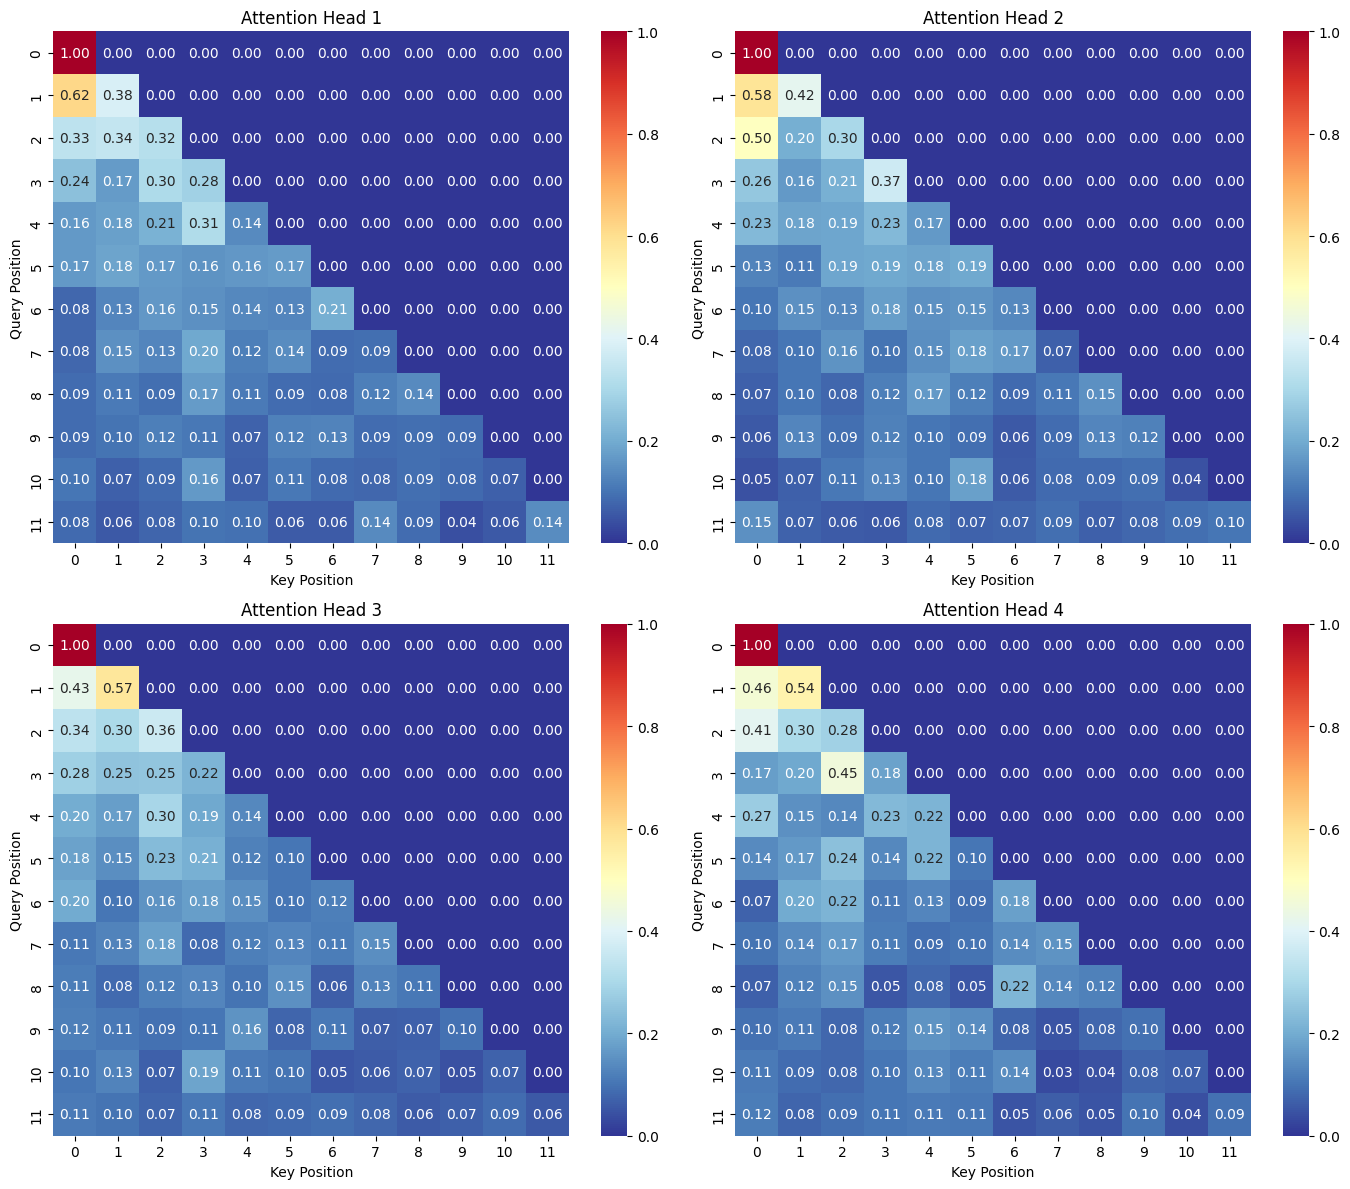

Each head learns different attention patterns:
- Some heads may focus on nearby tokens (local attention)
- Others may attend to distant tokens (global attention)
- The causal mask ensures no looking into the future


In [11]:
# Create a custom attention module to extract attention weights
class VisualizableAttention(nn.Module):
    """Modified attention that returns attention weights for visualization."""
    def __init__(self, n_embd: int, n_head: int):
        super().__init__()
        self.n_head = n_head
        self.head_dim = n_embd // n_head
        
        self.c_q = nn.Linear(n_embd, n_embd, bias=False)
        self.c_k = nn.Linear(n_embd, n_embd, bias=False)
        self.c_v = nn.Linear(n_embd, n_embd, bias=False)
        
    def forward(self, x, mask=None):
        B, T, C = x.shape
        
        q = self.c_q(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = self.c_k(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = self.c_v(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        
        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = F.softmax(scores, dim=-1)
        out = torch.matmul(attn_weights, v)
        
        return out, attn_weights

# Create visualizable attention
vis_attn = VisualizableAttention(n_embd=128, n_head=4)
x = torch.randn(1, 12, 128)
causal_mask = create_causal_mask(12)

_, attn_weights = vis_attn(x, mask=causal_mask)

# Visualize attention patterns for each head
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for head in range(4):
    sns.heatmap(
        attn_weights[0, head].detach().numpy(),
        annot=True, fmt='.2f', cmap='RdYlBu_r', cbar=True,
        ax=axes[head], vmin=0, vmax=1
    )
    axes[head].set_title(f'Attention Head {head + 1}')
    axes[head].set_xlabel('Key Position')
    axes[head].set_ylabel('Query Position')

plt.tight_layout()
plt.show()

print("Each head learns different attention patterns:")
print("- Some heads may focus on nearby tokens (local attention)")
print("- Others may attend to distant tokens (global attention)")
print("- The causal mask ensures no looking into the future")

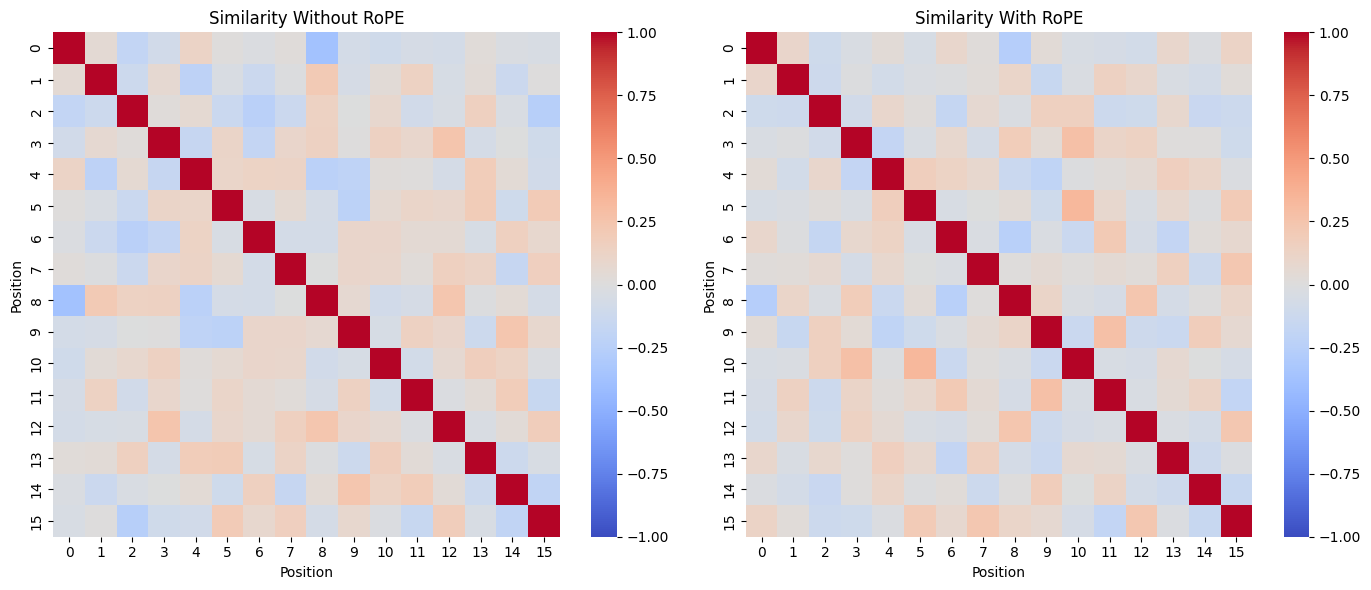

RoPE adds position-dependent patterns to embeddings:
- Nearby positions have similar rotations (higher similarity)
- Distant positions have different rotations (lower similarity)
- This helps the model learn relative position relationships


In [12]:
# Compare attention with and without RoPE
def compute_similarity_matrix(embeddings_with_rope, embeddings_without_rope):
    """Compute cosine similarity between positions."""
    # Normalize
    e_rope = F.normalize(embeddings_with_rope, dim=-1)
    e_no_rope = F.normalize(embeddings_without_rope, dim=-1)
    
    # Compute similarity matrices
    sim_rope = torch.matmul(e_rope, e_rope.transpose(-2, -1))
    sim_no_rope = torch.matmul(e_no_rope, e_no_rope.transpose(-2, -1))
    
    return sim_rope, sim_no_rope

# Create embeddings
seq_len = 16
dim = 64
embeddings = torch.randn(1, seq_len, dim)

# Apply RoPE
freqs_cis = precompute_freqs_cis(dim, seq_len)
embeddings_rope = apply_rotary_emb(embeddings, freqs_cis)

# Compute similarities
sim_rope, sim_no_rope = compute_similarity_matrix(embeddings_rope, embeddings)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(sim_no_rope[0].detach().numpy(), annot=False, cmap='coolwarm', 
            center=0, ax=ax1, vmin=-1, vmax=1)
ax1.set_title('Similarity Without RoPE')
ax1.set_xlabel('Position')
ax1.set_ylabel('Position')

sns.heatmap(sim_rope[0].detach().numpy(), annot=False, cmap='coolwarm',
            center=0, ax=ax2, vmin=-1, vmax=1)
ax2.set_title('Similarity With RoPE')
ax2.set_xlabel('Position')
ax2.set_ylabel('Position')

plt.tight_layout()
plt.show()

print("RoPE adds position-dependent patterns to embeddings:")
print("- Nearby positions have similar rotations (higher similarity)")
print("- Distant positions have different rotations (lower similarity)")
print("- This helps the model learn relative position relationships")

## Performance Comparison

Let's compare different attention configurations to understand the trade-offs.

In [13]:
import time

def benchmark_attention(n_embd, n_head, n_kv_head, seq_len, batch_size, num_iterations=100):
    """Benchmark attention forward pass."""
    attention = CausalSelfAttention(n_embd, n_head, n_kv_head, max_seq_len=seq_len)
    attention.eval()
    
    x = torch.randn(batch_size, seq_len, n_embd)
    
    # Warmup
    for _ in range(10):
        _ = attention(x)
    
    # Benchmark
    start_time = time.time()
    for _ in range(num_iterations):
        _ = attention(x)
    end_time = time.time()
    
    avg_time = (end_time - start_time) / num_iterations * 1000  # ms
    
    # Count parameters
    params = sum(p.numel() for p in attention.parameters())
    
    return avg_time, params

# Compare different configurations
configs = [
    ("Standard MHA", 256, 8, 8),
    ("GQA (4 KV heads)", 256, 8, 4),
    ("GQA (2 KV heads)", 256, 8, 2),
    ("MQA (1 KV head)", 256, 8, 1),
]

seq_len = 128
batch_size = 4

print(f"Benchmarking attention configurations (seq_len={seq_len}, batch={batch_size}):\n")
print(f"{'Configuration':<20} {'Params':<12} {'Time (ms)':<12} {'Speedup':<10}")
print("-" * 60)

baseline_time = None
for name, n_embd, n_head, n_kv_head in configs:
    avg_time, params = benchmark_attention(n_embd, n_head, n_kv_head, seq_len, batch_size)
    
    if baseline_time is None:
        baseline_time = avg_time
        speedup = "1.00x"
    else:
        speedup = f"{baseline_time / avg_time:.2f}x"
    
    print(f"{name:<20} {params:>10,}  {avg_time:>10.3f}  {speedup:>10}")

print("\n Key Insights:")
print("- GQA reduces parameters by using fewer KV heads")
print("- Memory usage decreases with fewer KV heads")
print("- MQA (1 KV head) offers maximum parameter efficiency")
print("- Trade-off between model capacity and computational efficiency")

Benchmarking attention configurations (seq_len=128, batch=4):

Configuration        Params       Time (ms)    Speedup   
------------------------------------------------------------
Standard MHA            262,144       1.737       1.00x
GQA (4 KV heads)        196,608       1.637       1.06x
GQA (2 KV heads)        163,840       1.470       1.18x
GQA (4 KV heads)        196,608       1.637       1.06x
GQA (2 KV heads)        163,840       1.470       1.18x
MQA (1 KV head)         147,456       1.276       1.36x

 Key Insights:
- GQA reduces parameters by using fewer KV heads
- Memory usage decreases with fewer KV heads
- MQA (1 KV head) offers maximum parameter efficiency
- Trade-off between model capacity and computational efficiency
MQA (1 KV head)         147,456       1.276       1.36x

 Key Insights:
- GQA reduces parameters by using fewer KV heads
- Memory usage decreases with fewer KV heads
- MQA (1 KV head) offers maximum parameter efficiency
- Trade-off between model capacity

KV Cache Efficiency Analysis:

Gen Length   Without Cache   With Cache   Speedup   
-------------------------------------------------------
10           55              10           5.5x
50           1275            50           25.5x
100          5050            100          50.5x
200          20100           200          100.5x
500          125250          500          250.5x


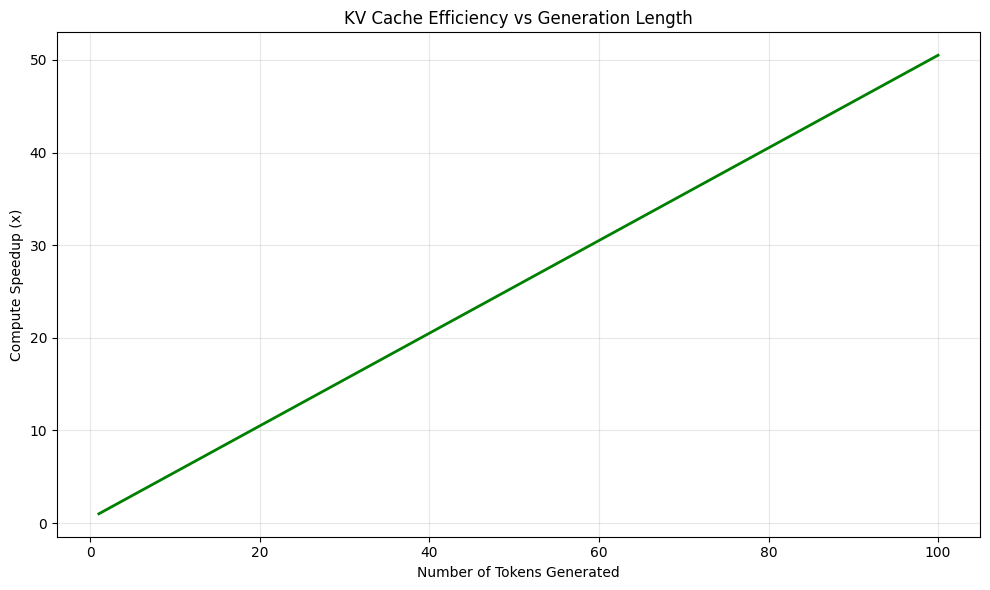


Key Insight: KV cache becomes increasingly valuable for longer generations
At 100 tokens: 50.5x speedup
Essential for efficient autoregressive generation in production


In [14]:
# Analyze memory and compute savings with KV cache
def analyze_kv_cache_savings(n_tokens_generated, n_embd, n_kv_head, head_dim):
    """
    Calculate FLOPs saved by using KV cache.
    
    Without cache: Recompute K,V for all previous tokens at each step
    With cache: Only compute K,V for new token
    """
    # Without cache: at step i, compute K,V for i tokens
    flops_without_cache = sum(range(1, n_tokens_generated + 1))
    
    # With cache: compute K,V for 1 token at each step
    flops_with_cache = n_tokens_generated
    
    savings_ratio = flops_without_cache / flops_with_cache
    
    return flops_without_cache, flops_with_cache, savings_ratio

# Analyze for different generation lengths
generation_lengths = [10, 50, 100, 200, 500]
n_embd = 256
n_kv_head = 4
head_dim = n_embd // 8

print("KV Cache Efficiency Analysis:\n")
print(f"{'Gen Length':<12} {'Without Cache':<15} {'With Cache':<12} {'Speedup':<10}")
print("-" * 55)

for gen_len in generation_lengths:
    without, with_cache, speedup = analyze_kv_cache_savings(gen_len, n_embd, n_kv_head, head_dim)
    print(f"{gen_len:<12} {without:<15} {with_cache:<12} {speedup:.1f}x")

# Visualize savings
gen_range = range(1, 101)
savings = [analyze_kv_cache_savings(i, n_embd, n_kv_head, head_dim)[2] for i in gen_range]

plt.figure(figsize=(10, 6))
plt.plot(gen_range, savings, linewidth=2, color='green')
plt.xlabel('Number of Tokens Generated')
plt.ylabel('Compute Speedup (x)')
plt.title('KV Cache Efficiency vs Generation Length')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey Insight: KV cache becomes increasingly valuable for longer generations")
print(f"At 100 tokens: {savings[-1]:.1f}x speedup")
print("Essential for efficient autoregressive generation in production")

## Exercises and Further Exploration

### Exercises:

1. **Experiment with Different Head Counts**: Try n_head = 4, 16, 32 and observe effects on attention patterns
2. **Compare GQA Ratios**: Test different n_head/n_kv_head ratios (2:1, 4:1, 8:1)
3. **Implement Cross-Attention**: Modify the code for encoder-decoder cross-attention
4. **Flash Attention Benchmarking**: Compare PyTorch's optimized vs custom attention
5. **Visualize Attention Entropy**: Analyze how "focused" different heads are

### Further Reading:

- **Original Attention Paper**: "Attention is All You Need" (Vaswani et al., 2017)
- **RoPE Paper**: "RoFormer: Enhanced Transformer with Rotary Position Embedding" (Su et al., 2021)
- **GQA Paper**: "GQA: Training Generalized Multi-Query Transformer" (Ainslie et al., 2023)
- **Flash Attention**: "FlashAttention: Fast and Memory-Efficient Exact Attention" (Dao et al., 2022)

### Advanced Topics:

- Sparse attention patterns
- Linear attention mechanisms
- Efficient attention for long sequences
- Multi-modal attention (vision + language)
- Attention visualization techniques

### Next Steps:

Continue with notebook 04 to learn about complete transformer blocks that combine attention with feed-forward networks and layer normalization!

## Conclusion

In this notebook, we've implemented a complete attention mechanism from scratch, following modern transformer architectures. Let's summarize the key components and insights.

### Components Implemented:

1. **Scaled Dot-Product Attention**: The foundation of all attention mechanisms
2. **Causal Masking**: Ensures autoregressive property for language modeling
3. **Multi-Head Attention**: Parallel attention operations for diverse representations
4. **Rotary Position Embeddings (RoPE)**: Superior positional encoding through rotation
5. **Grouped Query Attention (GQA)**: Efficient attention with fewer KV heads
6. **KV Caching**: Essential optimization for fast autoregressive generation
7. **Flash Attention**: Leveraging PyTorch's `scaled_dot_product_attention` for speed

### Key Insights from Modern Transformer Research:

- **RoPE > Absolute PE**: Rotary embeddings capture relative positions better
- **GQA Efficiency**: Reducing KV heads maintains quality while saving memory
- **KV Cache is Essential**: Provides quadratic speedup for generation
- **RMS Normalization**: Applied to queries and keys after RoPE
- **Separate Q/K/V Projections**: Better than combined QKV projection
- **Flash Attention**: Automatic optimization when using PyTorch's built-in function

### Performance Characteristics:

| Configuration | Parameters | Memory | Speed |
|--------------|-----------|---------|-------|
| Standard MHA | Baseline | Baseline | Baseline |
| GQA (4 heads) | -25% | -25% | Similar |
| GQA (2 heads) | -50% | -50% | Similar |
| MQA (1 head) | -75% | -75% | Faster |

### Applications:

- **Language Models**: GPT-style autoregressive generation
- **Machine Translation**: Encoder-decoder attention
- **Question Answering**: Attending to relevant context
- **Image Transformers**: Vision tasks with patch-based attention

This attention mechanism is the core of modern transformer models and enables their remarkable capabilities across diverse tasks.